In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pygmsh
import numpy as np
import jax.numpy as jnp
from dctkit.mesh import util, simplex
from dctkit.math.opt import optctrl
from dctkit.physics.elasticity import LinearElasticity
import dctkit.dec.cochain as C
import dctkit as dt
from matplotlib.pyplot import triplot
import matplotlib.pyplot as plt

In [3]:
dt.config()

In [4]:
lc = 0.1
L = 1.
with pygmsh.geo.Geometry() as geom:
    p = geom.add_polygon([[0., 0.], [L, 0.], [L, L], [0., L]], mesh_size=lc)
    # create a default physical group for the boundary lines
    geom.add_physical(p.lines, label="boundary")
    geom.add_physical(p.lines[0], label="down")
    geom.add_physical(p.lines[2], label="up")
    geom.add_physical(p.lines[1], label="right")
    geom.add_physical(p.lines[3], label="left")
    mesh = geom.generate_mesh()

S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_DPD_weights()
S.get_flat_DPP_weights()
S.get_flat_PDP_weights()
ref_node_coords = S.node_coords
_ = S.get_deformation_gradient(ref_node_coords)

In [5]:
down_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "down")
up_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "up")
down_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "down")
up_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "up")
left_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "left")
right_bnd_nodes_idx = util.get_nodes_for_physical_group(mesh, 1, "right")
left_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "left")
right_bnd_edges_idx = util.get_edges_for_physical_group(S, mesh, "right")

In [17]:
mu_ = 1.
lambda_ = 10.
a = 0.04
b = 0.1*a


true_curr_node_coords = ref_node_coords.copy()
true_curr_node_coords[:,0] = ref_node_coords[:,0] - b*ref_node_coords[:,0]**2 
true_curr_node_coords[:,1] = ref_node_coords[:,1] + a*ref_node_coords[:,1]**2 - a
disp_true = true_curr_node_coords - ref_node_coords

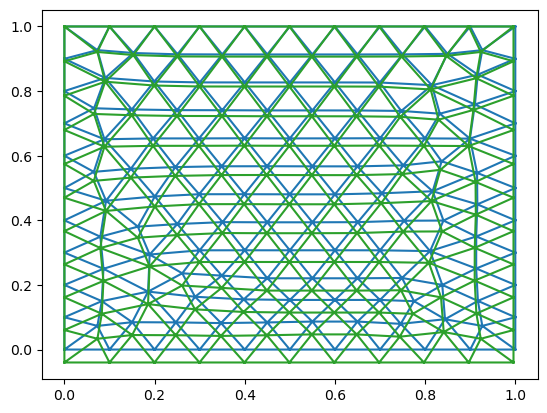

In [18]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(true_curr_node_coords[:,0], true_curr_node_coords[:,1], triangles=S.S[2])
plt.show()

In [19]:
# boundary conditions
up_bnd_pos = true_curr_node_coords[up_bnd_nodes_idx, :]
down_bnd_pos = true_curr_node_coords[down_bnd_nodes_idx, :]
left_bnd_pos = true_curr_node_coords[left_bnd_nodes_idx, :]
right_bnd_pos = true_curr_node_coords[right_bnd_nodes_idx, :]

bnodes = left_bnd_nodes_idx + right_bnd_nodes_idx + up_bnd_nodes_idx + down_bnd_nodes_idx
bvalues = true_curr_node_coords[bnodes,:]
#bvalues = np.vstack((left_bnd_pos, right_bnd_pos, up_bnd_pos, down_bnd_pos))
boundary_values = {":": (bnodes, bvalues)}

# body forces
f = np.zeros((S.num_nodes, 3), dtype = dt.float_dtype)


#penalty
gamma = 1000000.

ela = LinearElasticity(S=S, mu_=mu_, lambda_=lambda_)
true_node_coch = C.CochainP0(S, true_curr_node_coords)
f_coch = C.star(ela.get_dual_balance(true_node_coch, dict()))
f[:, :-1] = -f_coch.coeffs
print(f)

obj = ela.obj_linear_elasticity_energy
x0 = S.node_coords.flatten()
obj_args = {'f': f, 'gamma': gamma, 'boundary_values': boundary_values}

[[ 2.25376609e-01 -2.58358552e-01  0.00000000e+00]
 [-1.77736025e-01 -2.18047288e-01  0.00000000e+00]
 [ 2.25376609e-01 -2.58358552e-01  0.00000000e+00]
 [-1.77736025e-01 -2.18047288e-01  0.00000000e+00]
 [ 4.91772476e-02  1.22905120e-02  0.00000000e+00]
 [ 1.02412921e-01  2.07447618e-04  0.00000000e+00]
 [ 1.08337886e-01  9.35837546e-04  0.00000000e+00]
 [ 8.93703656e-02 -7.29564027e-04  0.00000000e+00]
 [ 8.69970639e-02 -5.16480599e-04  0.00000000e+00]
 [ 9.86666667e-02 -7.40641097e-14  0.00000000e+00]
 [ 1.31566333e-01  2.16293351e-03  0.00000000e+00]
 [ 3.78388020e-02 -1.20257887e-02  0.00000000e+00]
 [ 2.07162131e-01  3.93637463e-02  0.00000000e+00]
 [-4.51445486e-02 -1.05795026e+00  0.00000000e+00]
 [-5.83345787e-03 -9.88994520e-01  0.00000000e+00]
 [ 1.77366472e-04 -9.88986463e-01  0.00000000e+00]
 [ 3.56702941e-03 -9.88011694e-01  0.00000000e+00]
 [-2.90673845e-04 -9.95689657e-01  0.00000000e+00]
 [-2.21724275e-02 -9.80972557e-01  0.00000000e+00]
 [ 1.80837272e-02 -9.66416170e-

In [9]:
prb = optctrl.OptimizationProblem(dim=len(x0), state_dim=len(x0),objfun=obj)

prb.set_obj_args(obj_args)
sol = prb.solve(x0=x0, ftol_abs=1e-12, ftol_rel=1e-12, maxeval = 20000)
print(prb.last_opt_result)
curr_node_coords = sol.reshape(S.node_coords.shape)

1


In [10]:
print(ela.obj_linear_elasticity_energy(curr_node_coords, f,gamma, boundary_values))
print("--------------------")
print(ela.obj_linear_elasticity_energy(true_curr_node_coords, f, gamma, boundary_values))

-0.07879928928883076
--------------------
-0.07879912788994047


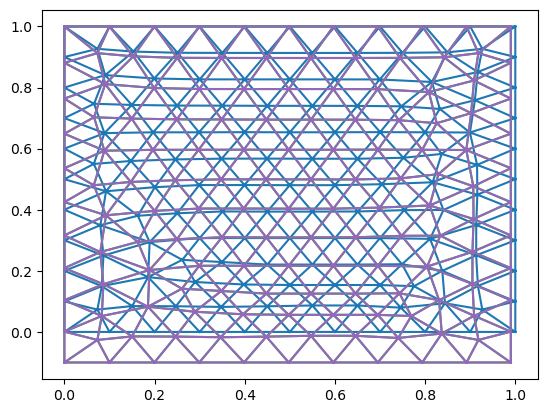

In [11]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords[:,0], curr_node_coords[:,1], triangles=S.S[2])
triplot(true_curr_node_coords[:,0], true_curr_node_coords[:,1], triangles=S.S[2])
plt.show()

In [12]:
err = np.linalg.norm(sol-true_curr_node_coords.flatten())**2
print(err)

6.832402637716014e-13


In [13]:
rotation_matrix = jnp.array(
                [[jnp.cos(jnp.pi/6), -jnp.sin(jnp.pi/6), 0], [jnp.sin(jnp.pi/6), jnp.cos(jnp.pi/6), 0], [0, 0, 1]])
rotation_tensor = jnp.stack([rotation_matrix]*S.num_nodes)

disp_computed = curr_node_coords - ref_node_coords 
disp_computed_star =  jnp.einsum("ijk, ik -> ij", rotation_tensor, disp_computed)
disp_true_star =  jnp.einsum("ijk, ik -> ij", rotation_tensor, disp_true)

curr_node_coords_star = ref_node_coords + disp_computed_star
true_curr_node_coords_star = ref_node_coords + disp_true_star

f_star = jnp.einsum("ijk, ik -> ij", rotation_tensor, f)


#bvalues_star = true_curr_node_coords_star[bnodes,:]
#boundary_values_star = {":": (bnodes, bvalues_star)}

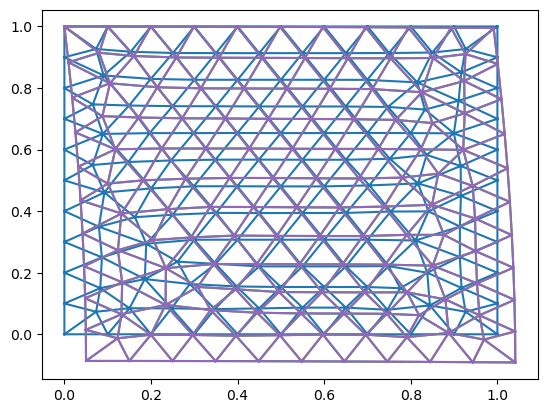

In [14]:
triplot(ref_node_coords[:,0], ref_node_coords[:,1], triangles=S.S[2])
triplot(curr_node_coords_star[:,0], curr_node_coords_star[:,1], triangles=S.S[2])
triplot(true_curr_node_coords_star[:,0], true_curr_node_coords_star[:,1], triangles=S.S[2])
plt.show()